# MCMC for optimizing the 2-layer multiple output Neural Network

Now with dask for distributed computing

Note this code follows variable output in `NN_opt_plot.ipynb`

In [1]:
#from dask_jobqueue import PBSCluster
from ncar_jobqueue import NCARCluster

In [2]:
cluster = NCARCluster(project='p08010000')

In [3]:
cluster.scale(2)

In [4]:
from dask.distributed import Client

In [5]:
client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.7:36293 Dashboard: https://jupyterhub.ucar.edu/ch/user/kdagon/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


The dashboard URL only works for jupyterhub (NCARCluster settings?)

In [6]:
import dask

In [7]:
dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"});

In [8]:
client

Client Scheduler: tcp://10.148.0.7:36293 Dashboard: /proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
client.close()
cluster.close()

In [10]:
import numpy as np
import matplotlib.pyplot as plt

List input variables

In [15]:
in_vars = ['medlynslope','dleaf','kmax','fff','dint','baseflow_scalar']
npar = len(in_vars)

In [21]:
var = ["GPP", "LHF"]
nvar = len(var)

Read in trained NN models

In [18]:
import keras.backend as K
from keras.models import load_model

Using TensorFlow backend.


In [19]:
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)

In [23]:
NN_models = [load_model("../emulators/NN_"+v+"_finalize_multi-dim.h5", 
    custom_objects={'mean_sq_err' :mean_sq_err}) for v in var]

In [24]:
Fobs = [np.load("../obs/obs_"+v+"_SVD_3modes.npy") for v in var]

In [25]:
obs_sd = [np.load("../obs/obs_"+v+"_SVD_3modes_allyrs_sd.npy") for v in var]

Set % variance explained (for weighted loss function)

In [26]:
# variance recorded in NN develop and test spreadsheet, taken from SVD.ipynb
var_modes = [[0.83406484, 0.1348919, 0.01192334],[0.7701996, 0.12915632, 0.05642754]]
#var_modes[0]

MCMC

In [9]:
import emcee

Cost function for MCMC

In [11]:
def normerr_MCMC(x):
    xt = x.reshape(1,-1)
    NN_preds = [NN_models[i].predict(xt) for i,v in enumerate(var)]
    terms = [np.sum(var_modes[i]*((NN_preds[i]-Fobs[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)]
    L = -(np.sum(terms)) # unweighted sum (as in, no scaling factor for LHF)
    return L

Define the prior

In [12]:
def lnprior(x):
    #if x.any() >= 0 and x.any() <= 1:
    #if all(x > 0) and all(x < 1):
    if np.all(x > 0) and np.all(x < 1):
        return 0.0
    return -np.inf

Define full log prob function

In [13]:
def lnprob(x):
    lp = lnprior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + normerr_MCMC(x)

Number of walkers, number of dimensions = number of parameters

In [16]:
# Note that number of walkers is correlated with runtime
nwalkers = 100
ndim = npar

Initialize walkers (random initial states)\
Could be important to try different initial states here

In [17]:
p0 = [np.random.rand(ndim) for i in range(nwalkers)]
print(p0[35])
np.min(p0)

[0.79388304 0.55925156 0.83959724 0.85282084 0.0577628  0.83041735]


0.0007223460128406023

Initialize walkers with exact results of single-point optimization\
Though testing with a short chain doesn't appear to move (stays on optimal values, doesn't generate posterior distribution)

In [ ]:
#p0 = [res.x for i in range(nwalkers)]
#p0[35]

Intialize walkers in a tight ball around single-point optimization values

In [40]:
# Manually save parameter scalers from optimization results
opt_params_preserved = [5.35314627e-01, 9.98124407e-01, 3.08100513e-01, 1.05168812e-04,
       9.98661100e-01, 2.25861839e-04]
opt_params_preserved

[0.535314627,
 0.998124407,
 0.308100513,
 0.000105168812,
 0.9986611,
 0.000225861839]

This is not right - the p0 formulation creates initial values that can be outside of [0,1] bounds

In [29]:
#initial = res.x # result from single-point opt
#initial = opt_params_preserved
#print(initial)
#tol = 1*10**-2 # vary this parameter
#p0 = [np.array(initial) + tol * np.random.randn(ndim) for i in range(nwalkers)]
#print(np.var(p0[0])) # variance across p0
#print(p0[99])

[0.535314627, 0.998124407, 0.308100513, 0.000105168812, 0.9986611, 0.000225861839]
[0.5384698  1.00717307 0.31224536 0.00298787 0.98627261 0.01296834]


Set up sampler

In [28]:
# Serial
# need to re-run this cell every time I change epochs (or sampler will append new values)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

Run Sampler - TO DO: get this to integrate with dask?\
Possible solution is to try and get these function values (nwalkers, ndim, lnprob) as dask arrays, but even then calling the emcee function might not be able to integrate with dask

In [29]:
epochs = 1*10**4
result = sampler.run_mcmc(p0, epochs, progress=True)

100%|██████████| 10000/10000 [09:52<00:00, 16.88it/s]


Mean acceptance fraction

In [30]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.336


Plot progression

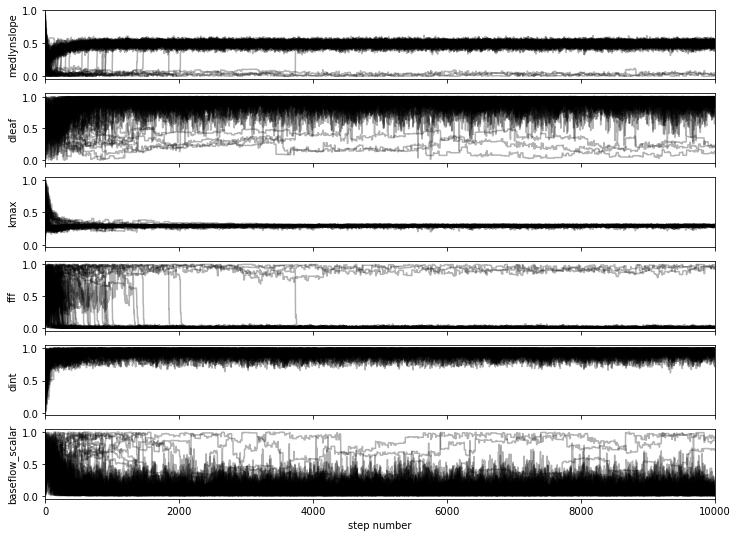

In [31]:
fig, axes = plt.subplots(ndim, figsize=(12, 9), sharex=True)
samples_all = sampler.get_chain()
labels = in_vars
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_all[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_all))
    ax.set_ylabel(labels[i])
    
axes[-1].set_xlabel("step number");
#plt.savefig("MCMC_sampler_chain_1e4epochs_correctobs_modewgt.png")

Plot log probability

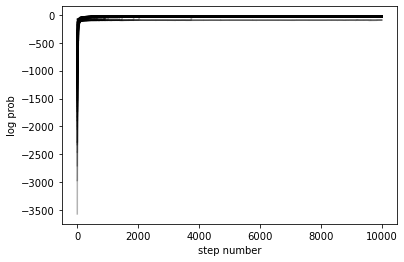

In [32]:
probs_all = sampler.get_log_prob()
#print(probs_all.shape)
plt.plot(probs_all, "k", alpha=0.3) # can't figure out the best way to plot this; too large to exponentiate
plt.xlabel("step number")
plt.ylabel("log prob");

Average log probability for last position of all walkers

In [33]:
print(np.mean(probs_all[epochs-1,:]))

-33.48772224801795


Get estimate of autocorrelation time - helps determine length of chain (number of epochs)

In [34]:
tau = sampler.get_autocorr_time()
print(tau) # do I need a longer chain? emcee will produce generalized estimates/guidance (i.e., run for epochs=50*tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [334.30293877 341.25654945 173.85373638 354.67492534 201.18830667
 317.98372251]

Plot autocorrelation using different estimates - first define some functions

In [35]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n
    # Optionally normalize
    if norm:
        acf /= acf[0]
    return acf

# automated windowing following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

Iterate over all dimensions and plot

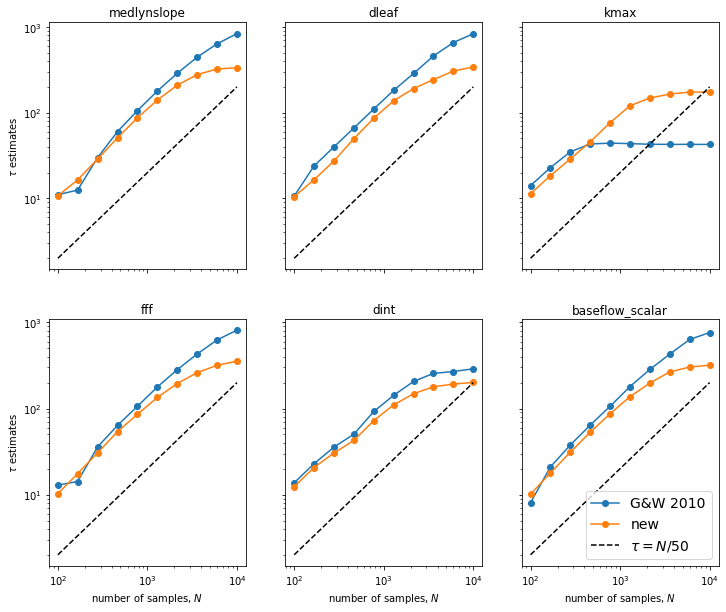

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize=(12, 10))
labels = in_vars
axes = axes.flatten()
for p in range(ndim):
    chain = samples_all[:,:,p].T
    N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
    gw2010 = np.empty(len(N))
    new = np.empty(len(N))

    for i, n in enumerate(N):
        gw2010[i] = autocorr_gw2010(chain[:, :n])
        new[i] = autocorr_new(chain[:, :n])

    # need to run for a long enough chain to get a meaningful figure
    ax = axes[p]
    ax.loglog(N, gw2010, "o-", label="G&W 2010")
    ax.loglog(N, new, "o-", label="new")
    #ylim = plt.gca().get_ylim()
    ax.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    #ax.set_ylim(ylim)
    ax.set_title(labels[p])
    
axes[3].set_xlabel("number of samples, $N$")
axes[4].set_xlabel("number of samples, $N$")
axes[5].set_xlabel("number of samples, $N$")
axes[0].set_ylabel(r"$\tau$ estimates")
axes[3].set_ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);
#plt.savefig("MCMC_autocorr_1e4epochs_correctobs_initopt_modewgt.pdf")

Plot distributions for final position

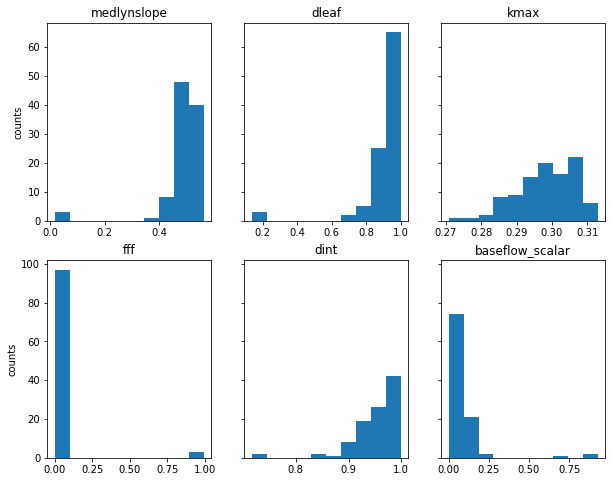

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey='row', figsize=(10, 8))
labels = in_vars
axes = axes.flatten()
for i in range(ndim):
    ax = axes[i]
    #ax.hist(sampler.chain[:,epochs-1,i], color="k", histtype="step")
    ax.hist(sampler.chain[:,epochs-1,i])
    ax.set_title(labels[i])

axes[0].set_ylabel("counts")
axes[3].set_ylabel("counts");

#plt.savefig("MCMC_lastsample_dist_1e4epochs_correctobs_initopt_v2_modewgt.pdf")

Corner plot

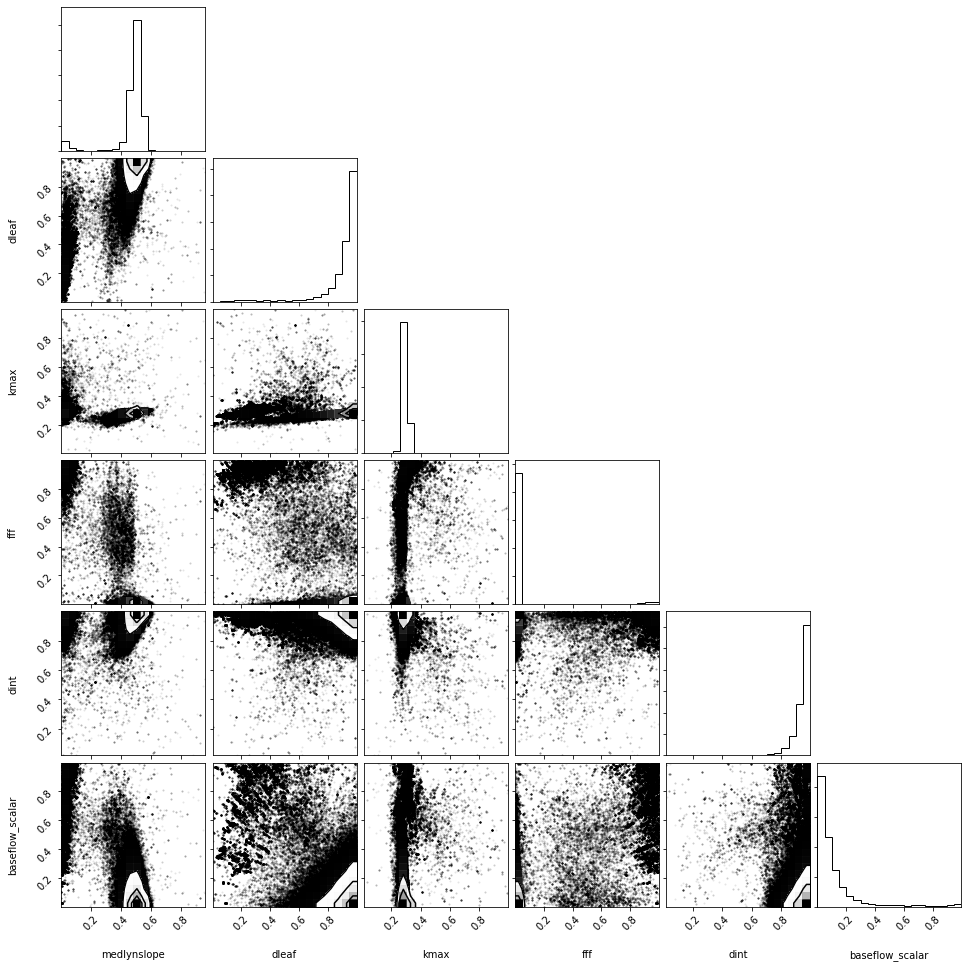

In [38]:
# discard the initial N steps
#flat_samples = sampler.get_chain(discard=10000, flat=True)
# no discard (faster convergence based on initialization)
flat_samples = sampler.get_chain(flat=True)
import corner
fig = corner.corner(flat_samples, labels=in_vars)
#plt.savefig("MCMC_corner_1e4epochs_correctobs_initopt_modewgt.pdf")

In [39]:
# final values for all walkers
last_sample = sampler.chain[:,epochs-1,:]
print(last_sample.shape)
print(np.mean(last_sample, axis=0)) # average (over walkers) last position of each parameter
#np.save("MCMC_posteriors/MCMC_last_sample_1e4epochs_correctobs_initopt_v2_modewgt", last_sample)

(100, 6)
[0.48578878 0.90981787 0.2982745  0.03455094 0.95139634 0.08704506]
